This project I built a time series forecasting model to predict the number of taxis that will be ordered in the next hour.

In [1]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import arma_order_select_ic
import warnings
warnings.filterwarnings('ignore')
import sys
from pmdarima import auto_arima

In [2]:
dataset = r'C:\Users\pjlaf\Documents\job\python for portfolio\time series\taxi.csv'
data = pd.read_csv(dataset, index_col=[0], parse_dates=[0])
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [3]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


### Resample the data with sum beacuse we want total rides in an hour rather than the average rides every 10 mintes for each hour.

In [4]:
data = data.resample('1H').sum()
print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: h
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB
None


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [5]:
print(f"MAX: {data['num_orders'].max()}\nMIN: {data['num_orders'].min()}\nMEAN: {data['num_orders'].mean()}")

MAX: 462
MIN: 0
MEAN: 84.42278079710145


In [6]:
print(f'MIN Date: {data.index.min()}\nMAX Date: {data.index.max()}')

MIN Date: 2018-03-01 00:00:00
MAX Date: 2018-08-31 23:00:00


In [7]:
data.isna().sum()

num_orders    0
dtype: int64

In [9]:
data.index = pd.to_datetime(data.index)

year = 2018
months = ['03','04','05','06','07','08']  
month_data = {m: [] for m in months}

for m in months:
    days_in_month = calendar.monthrange(year, int(m))[1]
    all_full = True  
    for d in range(1, days_in_month + 1):
        day_str = f'{d:02d}'  
        # Create a datetime for the current day
        day = pd.to_datetime(f'{year}-{m}-{day_str}')
        # Filter rows for this day
        day_data = data.loc[data.index.date == day.date()]
        hours_count = len(day_data)
        month_data[m].append(hours_count)
        
        if hours_count != 24:
            print(f'Day {d} of month {m} is not a full day of data.')
            all_full = False

    if all_full:
        print(f'All days in month {m} have 24 hours of data.')

All days in month 03 have 24 hours of data.
All days in month 04 have 24 hours of data.
All days in month 05 have 24 hours of data.
All days in month 06 have 24 hours of data.
All days in month 07 have 24 hours of data.
All days in month 08 have 24 hours of data.


Text(0.5, 1.0, 'Total Orders Per Day March - August')

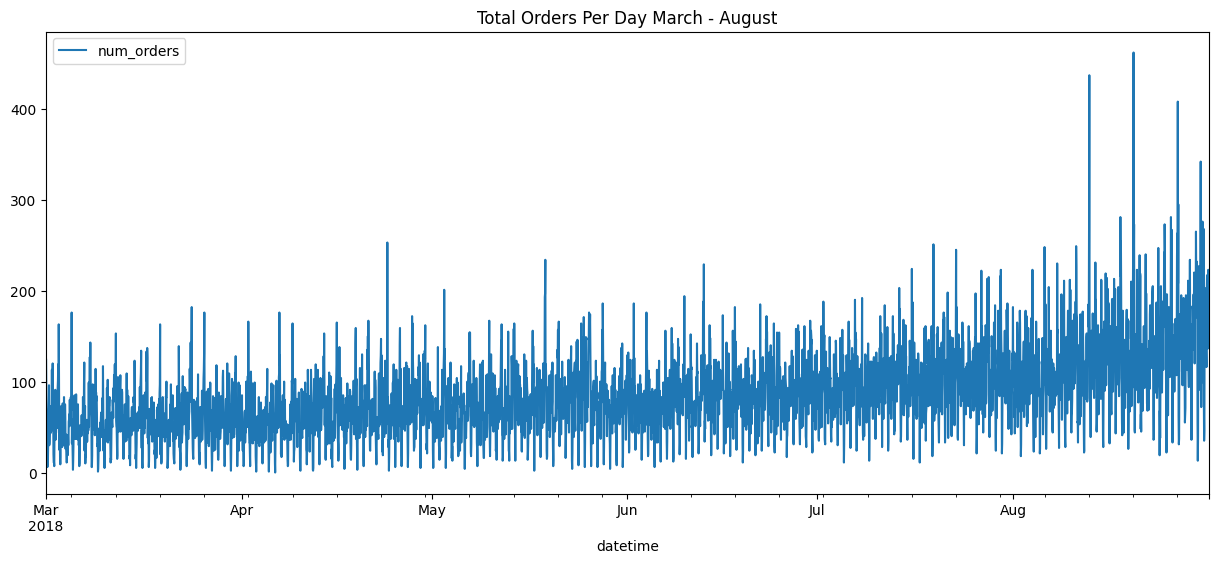

In [15]:
total_orders = data.plot(figsize=(15,6))
total_orders.set_title("Total Orders Per Day March - August")

### Trend, Seasonal, and Residual Data Visualization

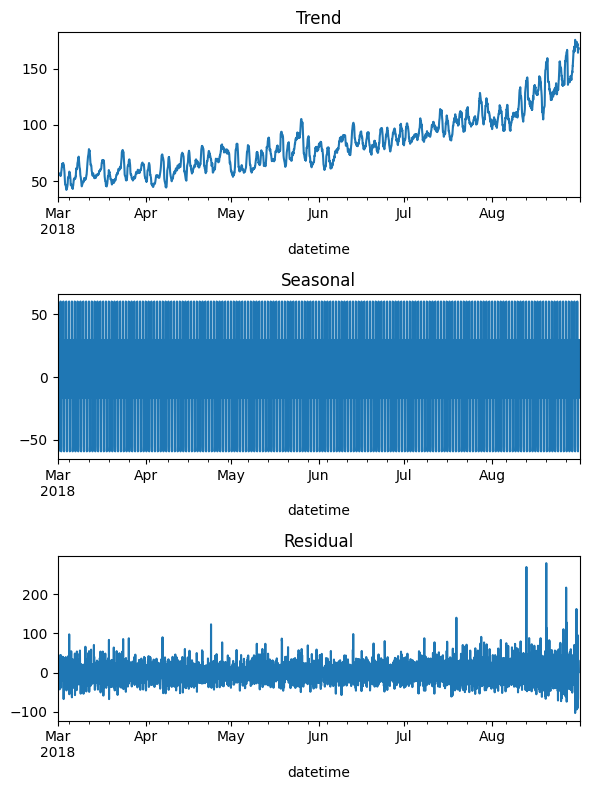

In [16]:
decomposed = seasonal_decompose(data)
plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonal')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residual')
plt.tight_layout()

### Seasonal data visualization for one month, one week and two week period

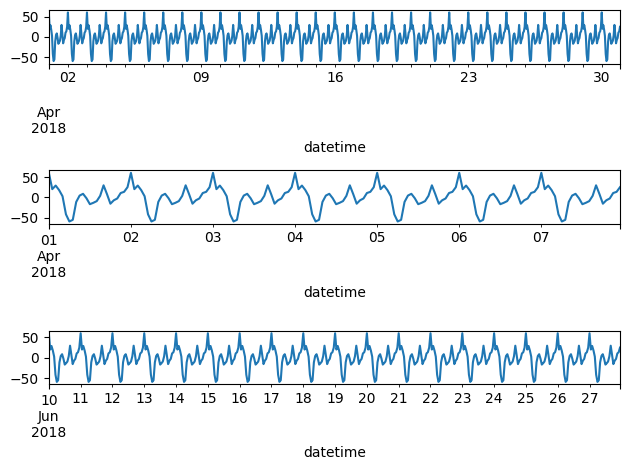

In [17]:
plt.subplot(311)
decomposed.seasonal['2018-04-01':'2018-04-30'].plot(ax=plt.gca())
plt.subplot(312)
decomposed.seasonal['2018-04-01':'2018-04-07'].plot(ax=plt.gca())
plt.subplot(313)
decomposed.seasonal['2018-06-10':'2018-06-27'].plot(ax=plt.gca())
plt.tight_layout()

<Axes: xlabel='datetime'>

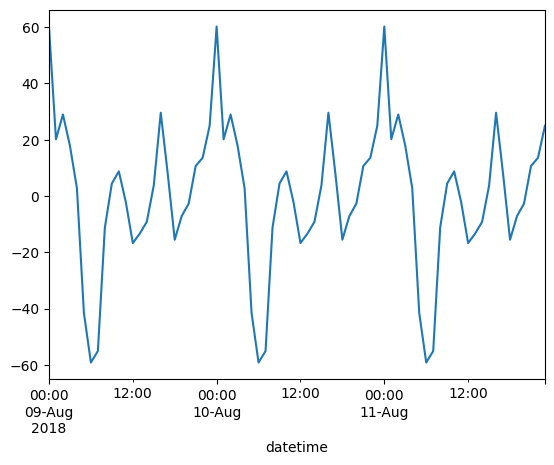

In [18]:
decomposed.seasonal['2018-08-9':'2018-08-11'].plot(ax=plt.gca())

### Breaking down the data by seasonality we can see that there are clear repetitions in the data. This pattern was hard to see while looking at the data as a whole, but when we broke it down into smaller time periods we can clearly see the pattern emerge. We can see there is a clear daily pattern of the peak demand for rides being around 12:00 pm.

In [19]:
data_features = data.copy()
def make_features(df, max_lag, rolling_mean_size):
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift(1).rolling(rolling_mean_size).mean()

make_features(data_features, 4, 4)
print(data_features.head())

                     num_orders  year  month  day  dayofweek  lag_1  lag_2  \
datetime                                                                     
2018-03-01 00:00:00         124  2018      3    1          3    NaN    NaN   
2018-03-01 01:00:00          85  2018      3    1          3  124.0    NaN   
2018-03-01 02:00:00          71  2018      3    1          3   85.0  124.0   
2018-03-01 03:00:00          66  2018      3    1          3   71.0   85.0   
2018-03-01 04:00:00          43  2018      3    1          3   66.0   71.0   

                     lag_3  lag_4  rolling_mean  
datetime                                         
2018-03-01 00:00:00    NaN    NaN           NaN  
2018-03-01 01:00:00    NaN    NaN           NaN  
2018-03-01 02:00:00    NaN    NaN           NaN  
2018-03-01 03:00:00  124.0    NaN           NaN  
2018-03-01 04:00:00   85.0  124.0          86.5  


## Linear Regression

In [20]:
train, test = train_test_split(data, test_size=0.10, shuffle=False)
features_train, features_test = train_test_split(data_features, test_size=0.10, shuffle=False)
print(features_train.shape)
print(features_test.shape)
print(train.shape)
print(test.shape)

(3974, 10)
(442, 10)
(3974, 1)
(442, 1)


### Autoregression Model

In [21]:
mod = ar_select_order(endog=data, maxlag=30)
ar_order = mod.ar_lags
len(ar_order)

28

In [25]:
ar_model = AutoReg(data, lags=ar_order, seasonal=True)
ar_model = ar_model.fit()
start_value = len(train)
end_value = len(train) + len(test) - 1
ar_pred = ar_model.predict(start=start_value, end=end_value, dynamic=False)
ar_rmse = mean_squared_error(test, ar_pred)
ar_rmse = np.sqrt(ar_rmse)
print(ar_rmse)

39.96018132826339


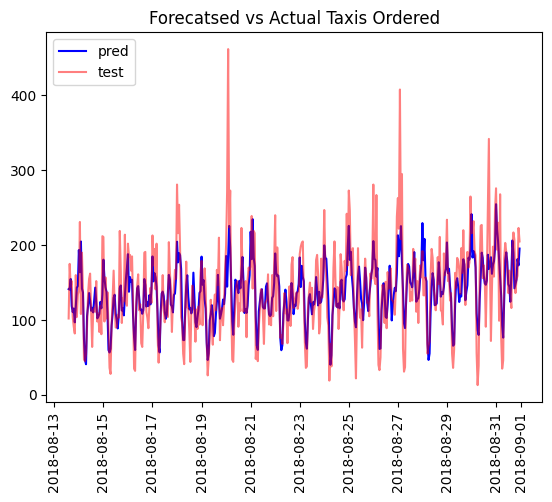

In [28]:
plt.plot(ar_pred, color='blue', label='pred')
plt.plot(test, color='red', label='test',alpha=0.50)
plt.legend(loc="upper left")
plt.xticks(rotation=90)
plt.title("Forecatsed vs Actual Taxis Ordered")
plt.show()